# Recreating the `demo_derangments_basic` model from the [work](https://qtechtheory.org/derangement_circuits/) of Balint Koczor
---

In [8]:
import sandbox_assets as sa
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from qiskit import QuantumCircuit
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_aer.noise import (NoiseModel, depolarizing_error)
from qiskit.quantum_info import SparsePauliOp

## The circuit
---

### The observable:

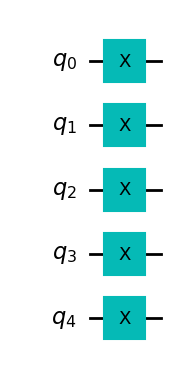

In [9]:
obs = QuantumCircuit(5)
obs.x(range(5))
obs.draw(style="default")

### The inital state:

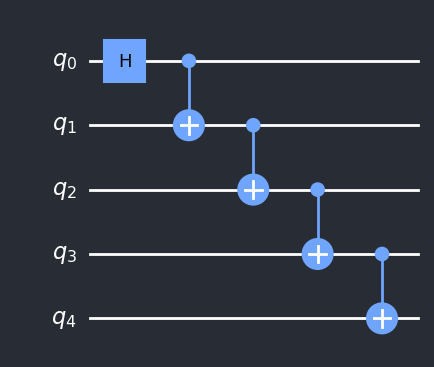

In [10]:
initial_state = QuantumCircuit(5)
sa.GHZ(initial_state)
initial_state.draw()

### The full circuit:

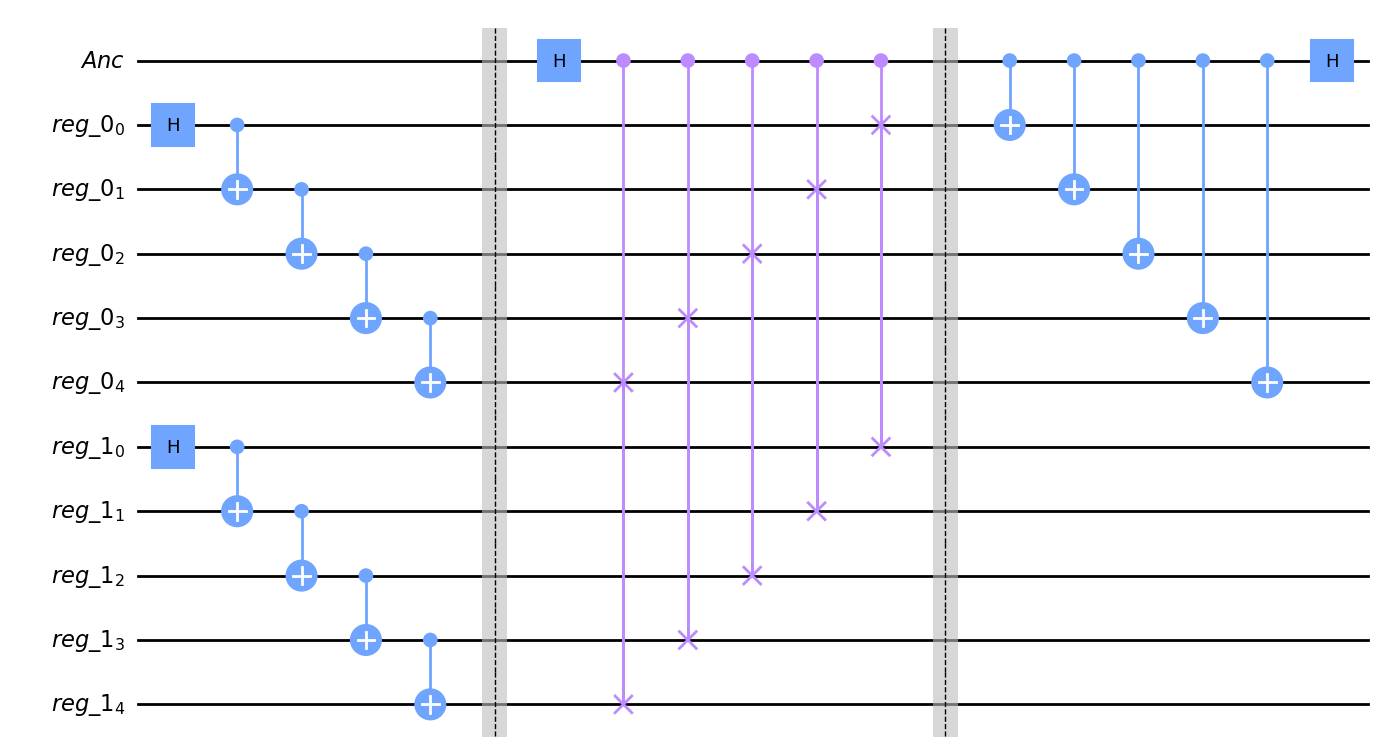

In [11]:
full_qc = sa.circAssembler(copies = 2, qubits = 5, ancilla_qubits = 1, initial_state = initial_state, obs = obs, 
                        basis_gates = ['cx', 'cswap', 'h'], der_op = True, opt_level = 0, seed = 1)

full_qc.draw(style="default")

## Expectation value
---

### Exact expectation value:
The known expectation value of the circuit is $1$. We can also check this using the `circ_tester()` function which returns the expectation value both for the mitigated and unmitigated (circuit without the derangement operator) circuits. 

#### Aer's density matrix method and the `cswap()` gate:

Unfortunatelly the density matrix method of the AerEstimator does not work for `cswap()` gates. However as we are not applying noise to these gates in this demo we can allow the estimator to recompile them, by redifining the `prob0` function:

In [12]:
def prob0_re(qc, nb_shots, noise_model, seed = 1):

    obs = SparsePauliOp((qc.num_qubits-1)*"I"+"Z")

    Estimator = AerEstimator(
        backend_options= {"noise_model": noise_model},
        run_options={"seed": seed, "shots" : nb_shots},
        skip_transpilation = False,  #<--- here
        approximation = True if nb_shots == None else False 
        )

    job = Estimator.run(qc, obs)
    result = job.result()
    exp_val = result.values[0]

    return(exp_val) 

In [13]:
sa.prob0 = prob0_re

In [15]:
copies = 2 # we create two copies 
qubits = 5 # each copy consists of 5 qubits (and 1 ancilla qubit)
sigma = obs # we are using the 'cnots' observable
basis_gates = ['cx', 'h', 'cswap'] # we are not decomposing the observable
nb_shots = None # we are interested in the exact (algeabraic) expectation value hence no shots # we calcualte the expectation value from the density matrix
noise_model = None # we are not applying noise at this point, see later sections

mit, unmit = sa.circTester(copies = copies, qubits = qubits, ancilla_qubits = 1, initial_state = initial_state,
                           obs = obs, basis_gates = basis_gates, nb_shots = nb_shots, noise_model = noise_model)

print('The mitigated expectation value is: {} and the unmitigated is: {}.'.format(mit, unmit))


The mitigated expectation value is: 0.9999999999999999 and the unmitigated is: 0.9999999999999999.


### Estimated expectation value, with the noise model from the demo:

In the mathematica demo, a depolarizing error with probability $p = 0.01$ is added to after each $CX$ gate of the $\text{GHZ}$ state. Here we reproduce the same noise model and obtain the expectation value first by performing the exact calculation second by estimating it using $10000$ shots.

In order to only apply the depolarizing error to the $CX$ gates for the $\text{GHZ}$ state and not for the observable, we redifine the $\text{GHZ}$ function by decomposing it into costum $CX$ gates:

1. Creating costum cx gate:

In [16]:
from qiskit.extensions import CXGate

In [17]:
costum_cx_gate = CXGate(label = "costum_cx")

2. redifining `GHZ()`, and creating new `initial_state`:

In [18]:
def GHZ_new(qc):

    registers = qc.qregs[:]
    numQubits = registers[0].size

    for reg in registers:
        qc.h(reg[0])

        for qubit in range(numQubits-1):
            qc.append(costum_cx_gate, (reg[qubit], reg[qubit+1])) # <-- redifining happens here!

In [20]:
sa.GHZ = GHZ_new

In [24]:
initial_state_new = QuantumCircuit(5)
sa.GHZ(initial_state_new)

Let's have a look at the new circuit:

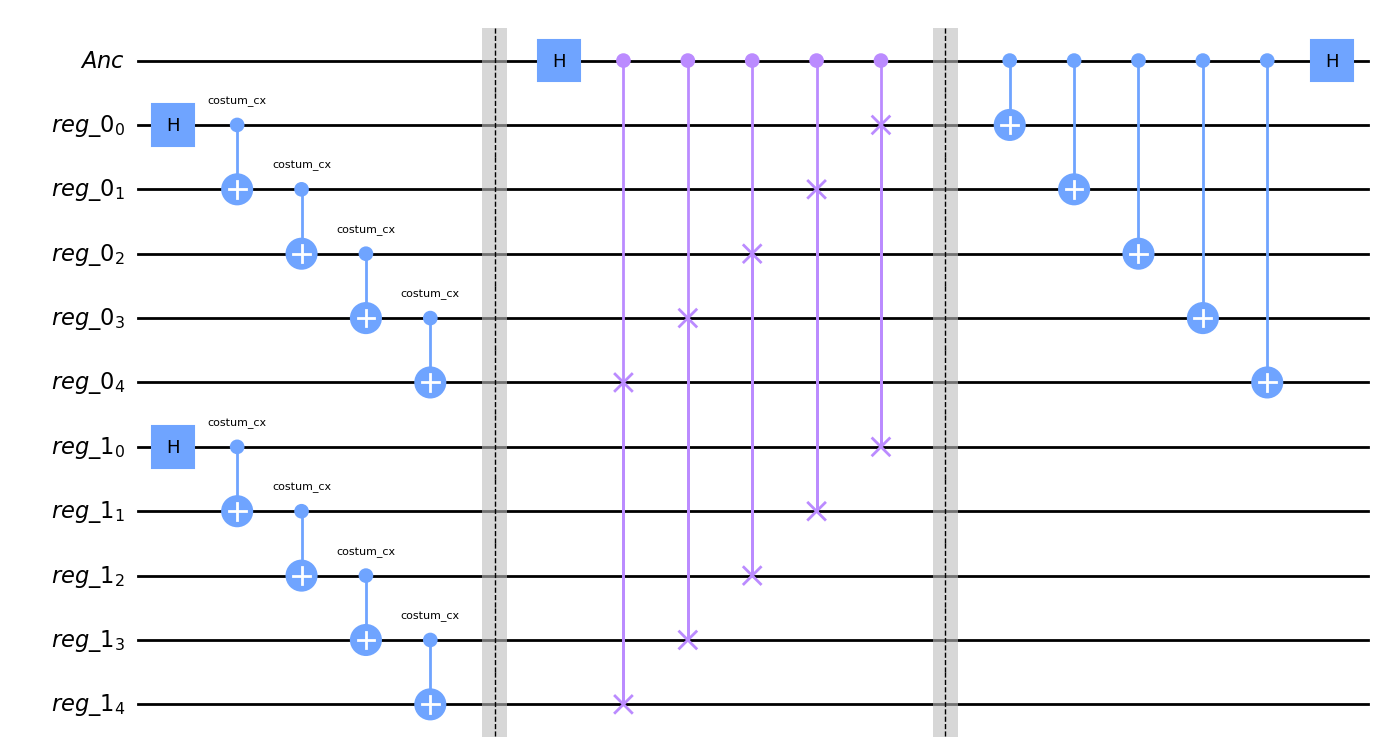

In [23]:
full_qc = sa.circAssembler(copies = 2, qubits = 5, ancilla_qubits = 1, initial_state = initial_state_new, obs = obs, 
                        basis_gates = ['cx', 'cswap', 'h'], der_op = True, opt_level = 0, seed = 1)

full_qc.draw(style="default")

#### Creating the noise model:

In [25]:
error = 0.01 # defining error probability

err_2q = depolarizing_error(error, 2) # 2 qubit error for costum cx gates in the GHZ state

noise_simple = NoiseModel() # create noise model
noise_simple.add_all_qubit_quantum_error(err_2q, costum_cx_gate.label)

noise_simple.add_basis_gates(['h', 'cx', 'cswap', 'costum_cx'])

print(noise_simple)

NoiseModel:
  Basis gates: ['cswap', 'cx', 'h', 'id', 'rz', 'sx']
  Instructions with noise: ['costum_cx']
  All-qubits errors: ['costum_cx']


Finally evaulting the circuit:

1. exact expectation value:

In [30]:
copies = 2 # we create two copies 
qubits = 5 # each copy consists of 5 qubits (and 1 ancilla qubit)
sigma = obs # we are using the 'cnots' observable
basis_gates = ['cx', 'h', 'cswap'] # we are not decomposing the observable
nb_shots = None # we are interested in the exact (algeabraic) expectation value hence no shots
noise_model = noise_simple # we 

mit, unmit = sa.circTester(copies = copies, qubits = qubits, ancilla_qubits = 1, initial_state = initial_state_new,
                           obs = obs, basis_gates = basis_gates, nb_shots = nb_shots, noise_model = noise_model)

print('The mitigated expectation value is: {},\nand the unmitigated is: {}.'.format(mit, unmit))


The mitigated expectation value is: 0.9998525577802065,
and the unmitigated is: 0.9605960100000005.


2. estimated expectation value using $100000$ shots:

In [31]:
copies = 2 # we create two copies 
qubits = 5 # each copy consists of 5 qubits (and 1 ancilla qubit)
sigma = obs # we are using the 'cnots' observable
basis_gates = ['cx', 'h', 'cswap'] # we are not decomposing the observable
nb_shots = 100000 # we are interested in the exact (algeabraic) expectation value hence no shots # we calcualte the expectation value from the density matrix
noise_model = noise_simple # we are not applying noise at this point, see later sections

mit, unmit = sa.circTester(copies = copies, qubits = qubits, ancilla_qubits = 1, initial_state = initial_state_new,
                           obs = obs, basis_gates = basis_gates, nb_shots = nb_shots, noise_model = noise_model)

print('The mitigated expectation value is: {},\nand the unmitigated is: {}.'.format(mit, unmit))


The mitigated expectation value is: 0.999892867090913,
and the unmitigated is: 0.96176.


In [33]:
copies = 2 # we create two copies 
qubits = 5 # each copy consists of 5 qubits (and 1 ancilla qubit)
sigma = obs # we are using the 'cnots' observable
basis_gates = ['cx', 'h', 'cswap'] # we are not decomposing the observable
seed = 1
nb_shots = None # we are interested in the exact (algeabraic) expectation value hence no shots

mit = [] # empty list for mitigated expectation values
unmit = [] # empty list for unmitigated expectation values

err_range = np.linspace(-3,-1, 10)

for error in tqdm(err_range):

    err_2q = depolarizing_error(10**error, 2) # 2 qubit error for costum cx gates in the GHZ state

    noise_simple = NoiseModel() # create noise model
    noise_simple.add_all_qubit_quantum_error(err_2q, costum_cx_gate.label)

    noise_simple.add_basis_gates(['h', 'cx', 'cswap', 'costum_cx'])

    mit_exp, unmit_exp = sa.circTester(copies = copies, qubits = qubits, ancilla_qubits = 1, initial_state = initial_state_new,
                           obs = obs, basis_gates = basis_gates, nb_shots = nb_shots, noise_model = noise_simple)

    mit.append(np.abs(mit_exp-1))
    unmit.append(np.abs(unmit_exp-1))

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:22<00:00,  2.23s/it]


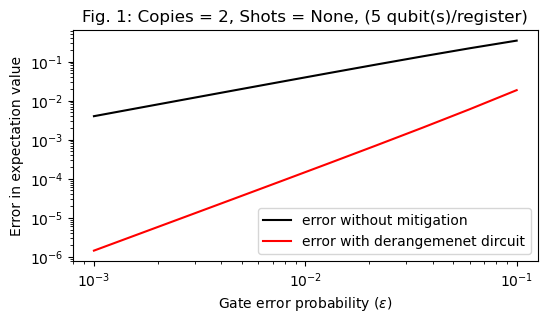

In [35]:
fig, ax = plt.subplots(figsize = (6, 3))

ax.loglog(10**err_range, unmit, color = 'black', label = 'error without mitigation')
ax.loglog(10**err_range, mit, color  = 'red', label = 'error with derangemenet dircuit')
#ax.hlines(1, 0, 0.5, color = 'mediumaquamarine', label = 'Known expectation value')
ax.legend()
ax.set(
       title ='Fig. 1: Copies = {}, Shots = {}, ({} qubit(s)/register)'.format(copies, nb_shots, qubits),
       xlabel = 'Gate error probability ($\epsilon$)', 
       ylabel = 'Error in expectation value'
)

plt.show()

The result from the [demo notebook]():

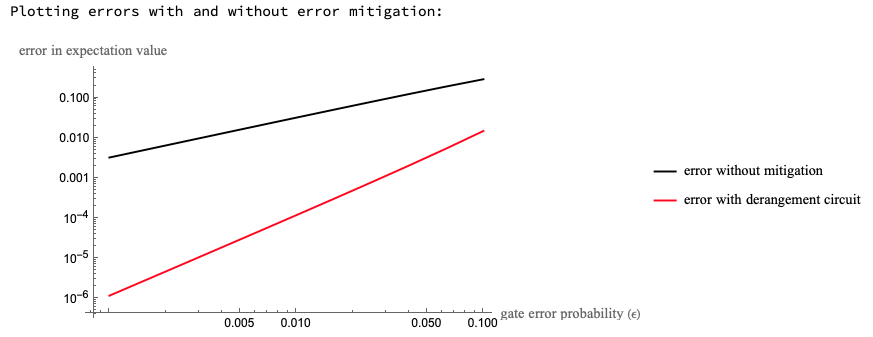